In [53]:
%pip install duckdb pandas jupysql matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Building Boilerplate below:
Using DuckDB will allows me to explore my Docker's LocalStack Gold Layer created.

In [54]:
import os 
import duckdb 

from dotenv import load_dotenv

load_dotenv()

conn = duckdb.connect()
conn.execute("INSTALL httpfs; LOAD httpfs;")
conn.execute(f"""
    SET s3_endpoint='{os.getenv("LOCALSTACK_ENDPOINT").replace("http://", "")}';
    SET s3_use_ssl=false;
    SET s3_url_style='path';
    SET s3_access_key_id='{os.getenv("AWS_ACCESS_KEY_ID")}';
    SET s3_secret_access_key='{os.getenv("AWS_SECRET_ACCESS_KEY")}';
    SET s3_region='{os.getenv("AWS_DEFAULT_REGION_ID")}';
""")

Using SQL to write my Star Schema Query

In [55]:
query = """
SELECT 
    c.coin_name, 
    f.price_usd, 
    d.full_timestamp,
    f.market_cap
FROM read_parquet('s3://crypto-raw-data/gold/fact_listings_*.parquet') f
JOIN read_parquet('s3://crypto-raw-data/gold/dim_coins_*.parquet') c ON f.coin_id = c.coin_id
JOIN read_parquet('s3://crypto-raw-data/gold/dim_date_*.parquet') d ON f.date_id = d.date_id
WHERE c.coin_name IN (
    'Bitcoin', 'Ethereum', 'Tether', 'Solana', 
    'Cardano', 'XRP', 'Dogecoin', 'BNB', 
    'Polkadot', 'Litecoin'
)
ORDER BY d.full_timestamp ASC;
"""

df_results = conn.execute(query).df()
print(df_results)

     coin_name      price_usd            full_timestamp    market_cap
0      Bitcoin  102078.085938 2025-01-06 00:00:00+00:00  0.000000e+00
1     Ethereum    3688.611328 2025-01-06 00:00:00+00:00  0.000000e+00
2       Solana     218.723129 2025-01-06 00:00:00+00:00  0.000000e+00
3          XRP       2.418807 2025-01-06 00:00:00+00:00  0.000000e+00
4      Cardano       1.094124 2025-01-06 00:00:00+00:00  0.000000e+00
...        ...            ...                       ...           ...
4937   Bitcoin   92172.622792 2026-01-06 19:35:00+00:00  1.840907e+12
4938  Dogecoin       0.145805 2026-01-06 19:35:00+00:00  2.452557e+10
4939   Cardano       0.408307 2026-01-06 19:35:00+00:00  1.467913e+10
4940   Bitcoin   92172.622792 2026-01-06 19:35:00+00:00  1.840907e+12
4941  Ethereum    3223.734623 2026-01-06 19:35:00+00:00  3.890881e+11

[4942 rows x 4 columns]


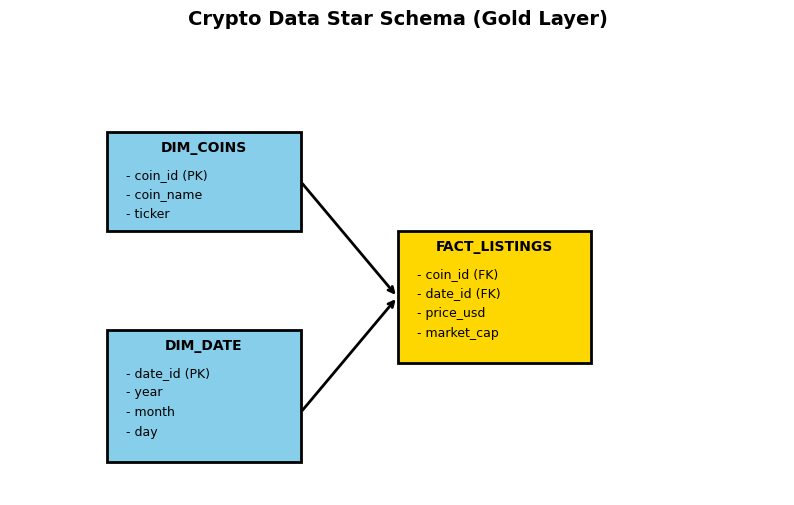

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def star_schema_design():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    tables = {
        "fact_listings": [4, 2, 2, 2, "gold"],
        "dim_coins": [1, 4, 2, 1.5, "skyblue"],
        "dim_date": [1, 0.5, 2, 2, "skyblue"]
    }
    
    for name, (x, y, w, h, color) in tables.items():
        rect = mpatches.Rectangle((x, y), w, h, linewidth=2, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        plt.text(x + w/2, y + h - 0.3, name.upper(), weight='bold', ha='center')
        
        if "fact" in name:
            cols = ["coin_id (FK)", "date_id (FK)", "price_usd", "market_cap"]
        elif "coins" in name:
            cols = ["coin_id (PK)", "coin_name", "ticker"]
        else:
            cols = ["date_id (PK)", "year", "month", "day"]
            
        for i, col in enumerate(cols):
            plt.text(x + 0.2, y + h - 0.7 - (i * 0.3), f"- {col}", fontsize=9)

    ax.annotate('', xy=(4, 3), xytext=(3, 4.75), arrowprops=dict(arrowstyle='->', lw=2))
    ax.annotate('', xy=(4, 3), xytext=(3, 1.25), arrowprops=dict(arrowstyle='->', lw=2))

    plt.xlim(0, 8)
    plt.ylim(0, 7)
    plt.axis('off')
    plt.title("Crypto Data Star Schema (Gold Layer)", fontsize=14, weight='bold')
    plt.show()

star_schema_design()

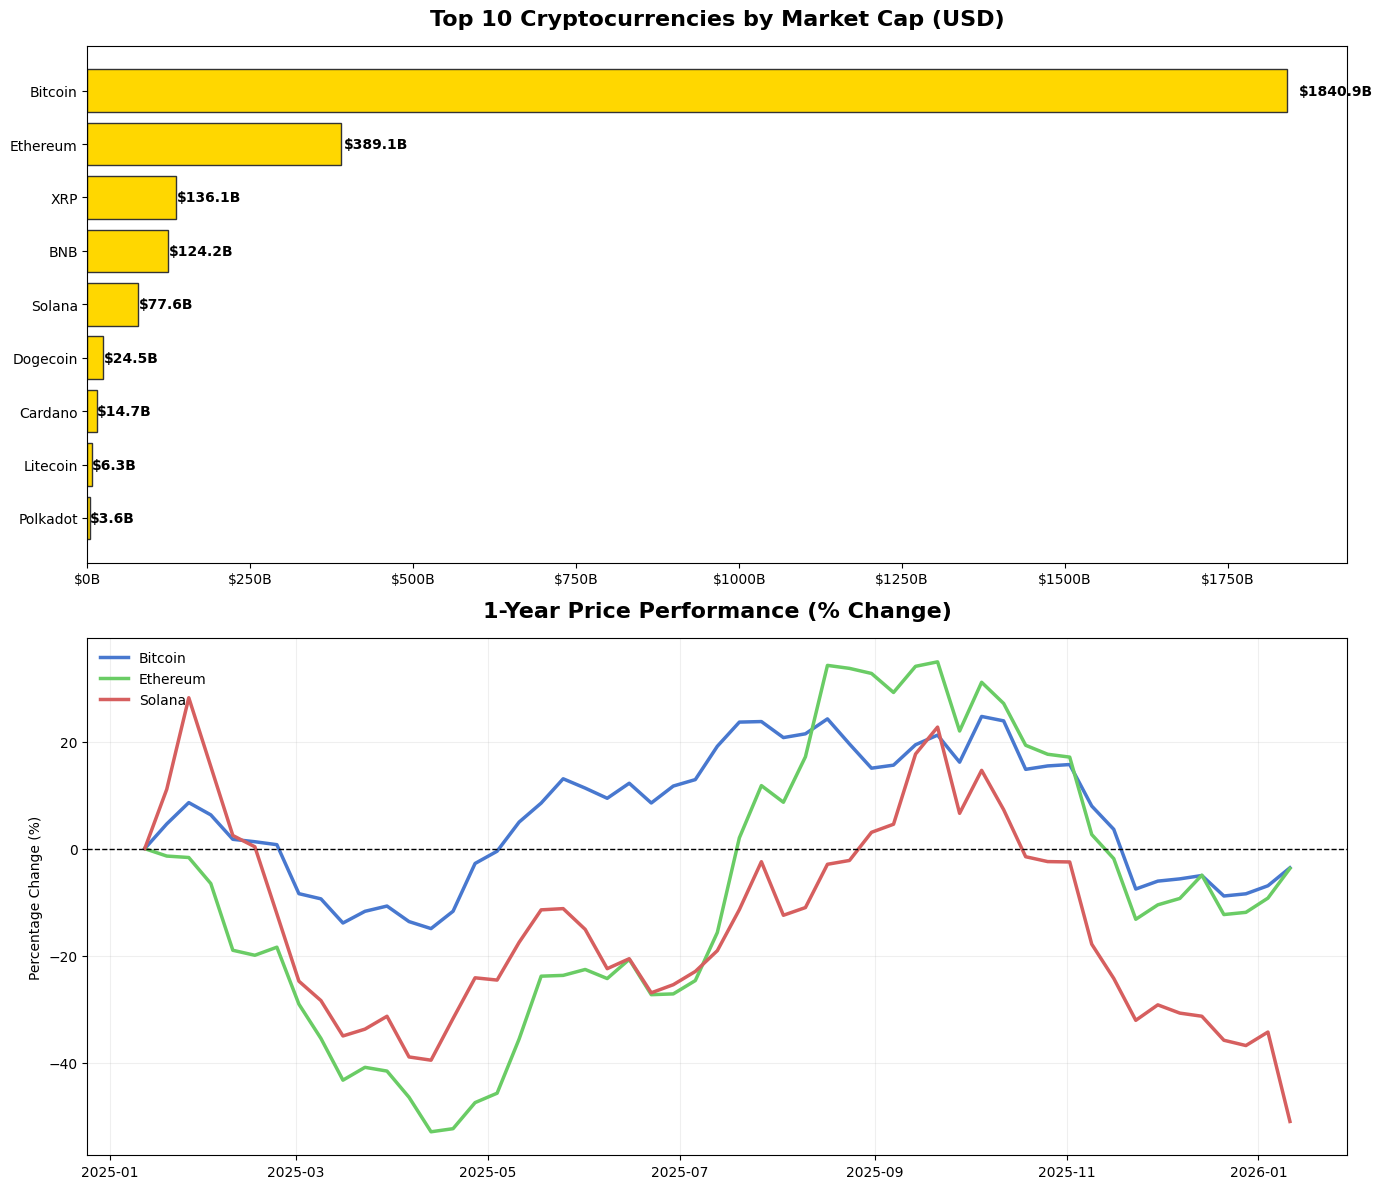

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

def plot_crypto_dashboard(df):
    df.columns = df.columns.str.lower().str.strip()
    df['full_timestamp'] = pd.to_datetime(df['full_timestamp'])
    
    df_latest = df.sort_values('full_timestamp', ascending=False).drop_duplicates('coin_name')
    top_10_cap = df_latest.sort_values('market_cap', ascending=True).tail(10)
    df_trend = df.sort_values('full_timestamp').set_index('full_timestamp')

    plt.style.use('seaborn-v0_8-muted')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Top 10 Market Cap Chart
    bars = ax1.barh(top_10_cap['coin_name'], top_10_cap['market_cap'], color='#FFD700', edgecolor='#333333')
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x*1e-9:.0f}B'))
    ax1.set_title('Top 10 Cryptocurrencies by Market Cap (USD)', fontsize=16, fontweight='bold', pad=15)
    
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + (width*0.01), bar.get_y() + bar.get_height()/2,
                f'${width*1e-9:.1f}B', va='center', fontweight='bold')

    # Weekly Trend Chart
    for coin in ['Bitcoin', 'Ethereum', 'Solana']:
        coin_df = df_trend[df_trend['coin_name'] == coin]
        weekly_df = coin_df['price_usd'].resample('W').mean().dropna()
        
        if len(weekly_df) > 1:
            base_price = weekly_df.iloc[0]
            pct_change = ((weekly_df - base_price) / base_price) * 100
            ax2.plot(weekly_df.index, pct_change, label=f"{coin}", linewidth=2.5)

    ax2.set_title('1-Year Price Performance (% Change)', fontsize=16, fontweight='bold', pad=15)
    ax2.set_ylabel('Percentage Change (%)')
    ax2.axhline(0, color='black', lw=1, ls='--')
    ax2.legend(loc='upper left', frameon=False)
    ax2.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

plot_crypto_dashboard(df_results)
